In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import shutil
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm.notebook import tqdm

## Data Preprocessing

In [ ]:
def extract_frames(video_path, num_frames=30):
    '''Function to extract frames from the video file.
        Args:
        video_path (str): Path to the video file.
        num_frames (int): Number of frames to extract.'''
    
    cap = cv2.VideoCapture(video_path)
    frame_count= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = list(np.linspace(0, frame_count-1, num_frames, dtype=int))

    frames = []
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        if i in frame_idxs:
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize frame to 224x224
            frame = cv2.resize(frame, (224, 224))
            # Normalize frame
            frame = frame / 255.0
            frames.append(frame)
        
    cap.release()
    return frames


def save_frames(dataset_path):
    '''Function to save the extracted frames to a directory.
        Args:
        dataset_path (str): Path to the dataset directory.'''
    
    videos = os.listdir(dataset_path)

    for video in videos:
        os.makedirs(f"{dataset_path}/{video.split('.')[0]}", exist_ok=True)
        video_path = os.path.join(dataset_path, video)
        frames = extract_frames(video_path, num_frames=30)

        for i, frame in enumerate(frames):
            plt.imsave(f"{dataset_path}/{video.split('.')[0]}/frame-{i}.jpg", frame)

        print(f"Frames extracted and saved for {video}")
    

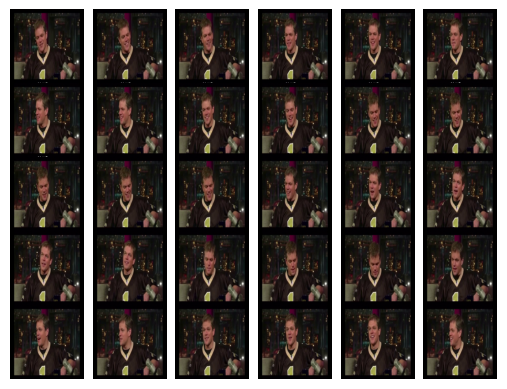

In [5]:
#Example usage of extract_frames function.
sample_frames = extract_frames('YouTube-real/00001.mp4')

for i in range(len(sample_frames)):
    plt.subplot(5, 6, i+1)
    plt.imshow(sample_frames[i])
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
celeb_real_path = 'real/'
celeb_synthesis_path = 'fake/'
youtube_real_path = 'YouTube-real/'

save_frames(celeb_real_path)
save_frames(celeb_synthesis_path)
save_frames(youtube_real_path)

Frames extracted and save for id0_0000
Frames extracted and save for id0_0000.mp4
Frames extracted and save for id0_0001
Frames extracted and save for id0_0001.mp4
Frames extracted and save for id0_0002
Frames extracted and save for id0_0002.mp4
Frames extracted and save for id0_0003
Frames extracted and save for id0_0003.mp4
Frames extracted and save for id0_0004
Frames extracted and save for id0_0004.mp4
Frames extracted and save for id0_0005
Frames extracted and save for id0_0005.mp4
Frames extracted and save for id0_0006
Frames extracted and save for id0_0006.mp4
Frames extracted and save for id0_0007
Frames extracted and save for id0_0007.mp4
Frames extracted and save for id0_0008
Frames extracted and save for id0_0008.mp4
Frames extracted and save for id0_0009
Frames extracted and save for id0_0009.mp4
Frames extracted and save for id10_0000
Frames extracted and save for id10_0000.mp4
Frames extracted and save for id10_0001
Frames extracted and save for id10_0001.mp4
Frames extra

In [2]:
class DatasetLoader(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label in ['real', 'fake']:
            class_dir = os.path.join(root_dir, label)
            for video_folder in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_folder)

                if not os.path.isdir(video_path):
                    continue  

                for frame_name in os.listdir(video_path):
                    frame_path = os.path.join(video_path, frame_name)
                    self.samples.append((frame_path, 0 if label == 'real' else 1))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Couldn't load image at {img_path}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, label
    
    @staticmethod
    def split_dataset(base_dir, output_dir=None, split_ratio=(0.7, 0.15, 0.15), seed=42):
        """
        Splits the dataset in base_dir into train/val/test and copies to output_dir.
        """
        random.seed(seed)
        output_dir = output_dir or (base_dir + '_split')
        categories = ['real', 'fake']

        for category in categories:
            category_dir = os.path.join(base_dir, category)
            videos = [d for d in os.listdir(category_dir) if os.path.isdir(os.path.join(category_dir, d))]
            random.shuffle(videos)

            n_total = len(videos)
            n_train = int(split_ratio[0] * n_total)
            n_val = int(split_ratio[1] * n_total)

            train_videos = videos[:n_train]
            val_videos = videos[n_train:n_train + n_val]
            test_videos = videos[n_train + n_val:]

            for split_name, split_videos in zip(['train', 'val', 'test'], [train_videos, val_videos, test_videos]):
                split_dir = os.path.join(output_dir, split_name, category)
                os.makedirs(split_dir, exist_ok=True)
                for vid in split_videos:
                    src = os.path.join(category_dir, vid)
                    dst = os.path.join(split_dir, vid)
                    if os.path.exists(dst):
                        continue
                    shutil.copytree(src, dst)
        
        print(f"[✔] Dataset split into train/val/test at: {output_dir}")


In [35]:
dataset = DatasetLoader(root_dir=os.getcwd())
dataset.split_dataset(os.getcwd(), output_dir='split_dataset')

[✔] Dataset split into train/val/test at: split_dataset


## Model Training

In [4]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
    ToTensorV2()
])

In [5]:
train_dataset = DatasetLoader(root_dir=os.getcwd(), transform=train_transform)
val_dataset = DatasetLoader(root_dir=os.getcwd(), transform=val_test_transform)
test_dataset = DatasetLoader(root_dir=os.getcwd(), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
def get_resnet_model():
    model = models.resnet152(pretrained=True)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet_model().to(device)


c:\Users\msaip\anaconda3\envs\tf_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\msaip\anaconda3\envs\tf_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()

    return correct / len(loader.dataset)

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        print(f"\nEpoch {epoch+1}/{epochs}")
        progress_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

            progress_bar = tqdm(train_loader, desc="Training", leave=False, position=0)

        val_acc = evaluate_model(model, val_loader)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {correct/len(train_loader.dataset):.4f} | Val Acc: {val_acc:.4f}")

# Assuming you already defined `model`, `device`, `train_loader`, `val_loader`
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10


Training:   0%|          | 0/5839 [00:00<?, ?it/s]

In [ ]:
print("Number of samples:", len(train_loader.dataset))
print("First batch:")
for images, labels in train_loader:
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break

Number of samples: 186841
First batch:


In [3]:
dataset = DatasetLoader(root_dir=os.getcwd())
print("Dataset size:", len(dataset))

image, label = dataset[0]
print("Sample shape:", image.shape)
print("Label:", label)

Dataset size: 186841
Sample shape: (224, 224, 3)
Label: 0
